 We want to measure the ``flatness'' of the output space of a neural network
 to then use the identity for sectional curvature as well as providing supporting
 evidence for the manifold hypothesis.

 Using the Local Diagonal RBF Kernel Metric, we can calculate the Riemannian curvature through both the pullback
 and local method. We compare pulling back w.r.t to the next layer, or the penultimate layer. We also comnpare 
 4 different metrics for evaluating the flatness of the output space via the Riemannian curvature tensor.

 We use the following dataset/model pairs:
 - Moons / 2 Wide MLP
 - Moons / 2 Wide Overfit MLP
 - Moons / 
 - Circles

 

In [5]:
import sys
sys.path.append("../../../")

import torch
import numpy as np
import os
import tqdm

from experiments.supervised.learning_dynamics.script import flatness_metrics, run_metric_calculations, generate_pullback_plots, generate_local_plots

from models.supervised.mlp.model import MLP
from models.data.sklearn_datasets import MoonDataset, SpiralDataset, BlobsDataset, CirclesDataset

models_path = "../../../models/supervised/mlp/saved_models"


In [6]:
np.random.seed(2)
torch.manual_seed(2)

In [7]:
mode = 'moon'
size = "blobs"

if mode == 'moon':
    dataset = MoonDataset(n_samples=1000, noise=0.01)
elif mode == 'blobs':
    dataset = BlobsDataset(n_samples=1000, noise=0.15, centers=4)
elif mode == 'spiral':
    dataset = SpiralDataset(n_samples=1000, noise=0.01)
elif mode == 'circles':
    dataset = CirclesDataset(n_samples=1000, noise=0.01)


Generating plots for skinny model at epoch 199
Generating manifold plots for layer_wise pullback
Rejected 249 points
Rejected 21 points
Generating manifold plots for output_wise pullback
Rejected 249 points
Rejected 21 points
Generating lattice plots for layer_wise pullback
Generating lattice plots for output_wise pullback
Generating lattice plots for local
figures/moon/skinny/199/local_lattice_ricci.png
Generating surface plots for local
figures/moon/skinny/199/local_surface_ricci.png


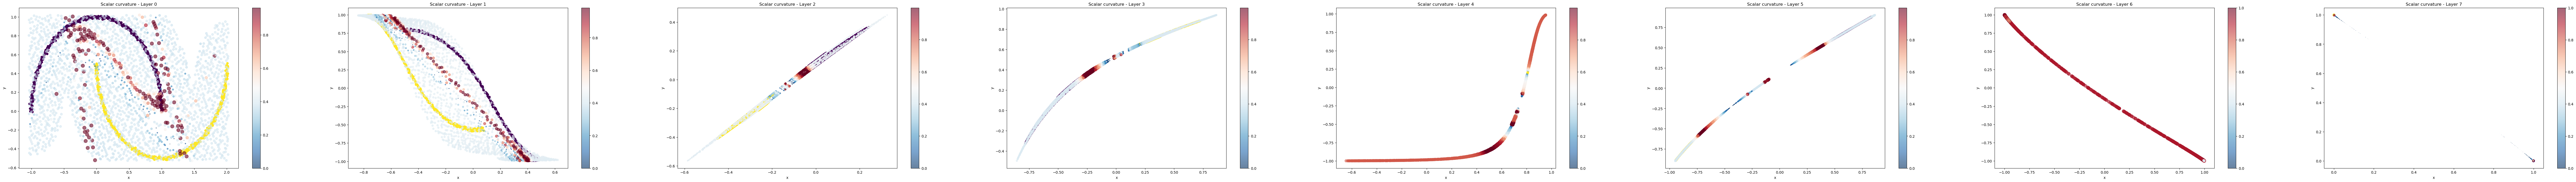

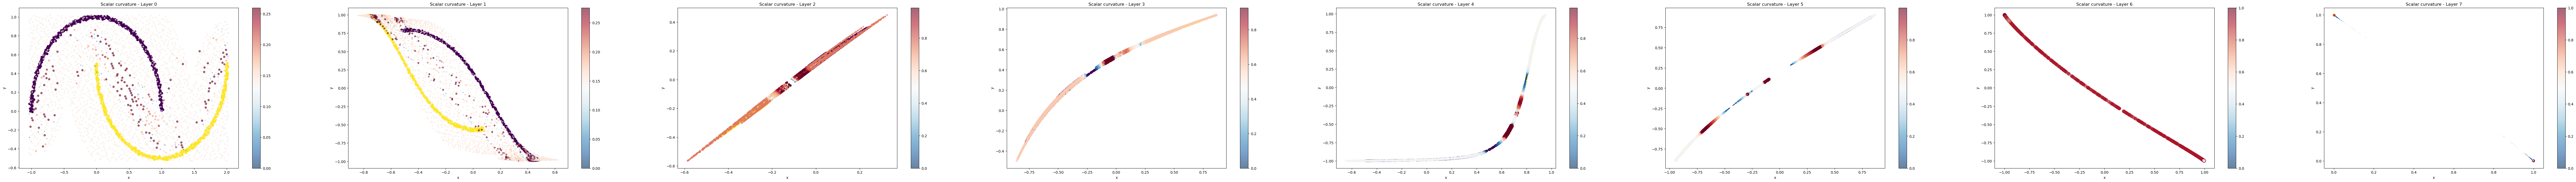

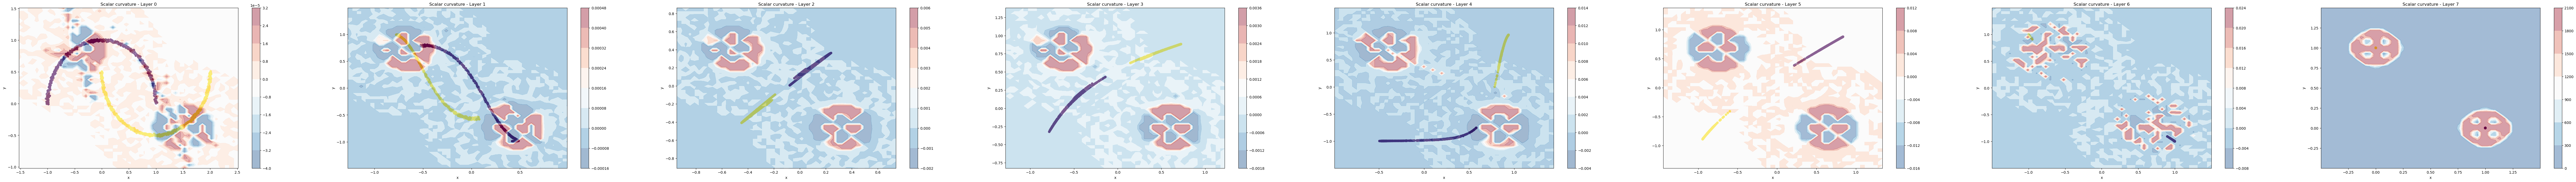

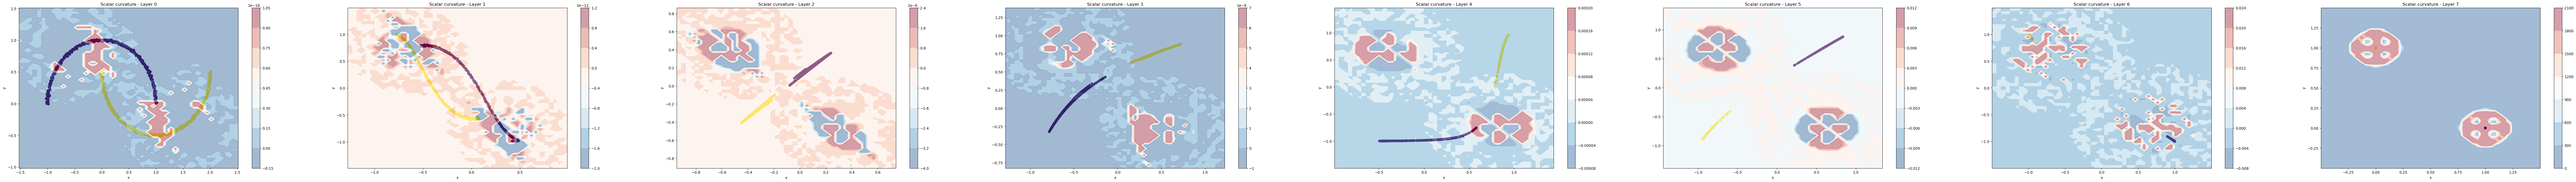

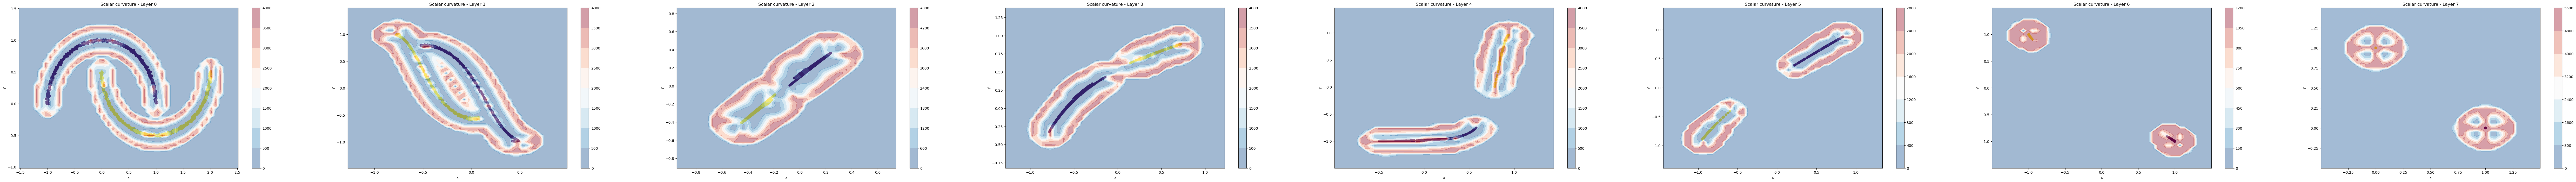

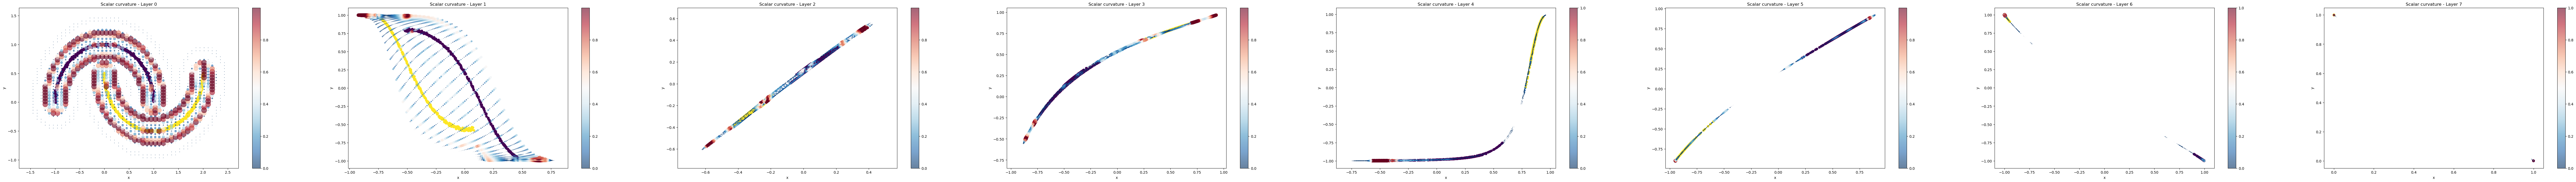

In [4]:
#%%capture

# Generate plots measuring curvature of space accross different models.

hyperparams = [["skinny", 199], ["overfit", 199], ["skinny", 5], ["overfit", 999], ["overfit", 9999]]
hyperparams = [["skinny", 199]]
for size, epoch in hyperparams:
    print(f"Generating plots for {size} model at epoch {epoch}")
    if size == "skinny":
        model = MLP(2,7,2,2)
        full_path = f'{models_path}/2_wide/mlp_{mode}/model_{epoch}.pth'
    elif size == "overfit":
        model = MLP(2,7,2,1)
        full_path = f'{models_path}/overfit/mlp_{mode}/model_{epoch}.pth'
    else:
        model = MLP(2,7,10,2)
        full_path = f'{models_path}/vanilla/mlp_{mode}/model_{epoch}.pth'
    model.load_state_dict(torch.load(full_path))
    if size == "overfit":
        model.layers = model.layers[:-1]
        model.num_layers = len(model.layers)
    
    model.eval()
    save_path = f"figures/{mode}/{size}/{epoch}/"
    os.makedirs(save_path, exist_ok=True)
    wrt = ["layer_wise", "output_wise"]

    methods = ["manifold", "lattice"]
    for method in methods:
        for w in wrt:
            print(f"Generating {method} plots for {w} pullback")
            generate_pullback_plots(model, dataset, 50, 15, save_path=save_path, wrt=w, method=method)

    methods = ["lattice", "surface"]
    for method in methods:
        print(f"Generating {method} plots for local")
        generate_local_plots(model, dataset, 50, 15, save_path=save_path, method=method)


    


In [ ]:
size = "skinny"

model = MLP(2,7,2,2)

final_results = []
for epoch in tqdm.tqdm([5, 60, 80, 199]):
    full_path = f'{models_path}/2_wide/mlp_{mode}/model_{epoch}.pth'
    model.load_state_dict(torch.load(full_path))
    
    model.eval()
    save_path = f"figures/{mode}/{size}/{epoch}/"
    os.makedirs(save_path, exist_ok=True)
    for pullback_method in ["layer_wise", "output_wise"]:
        results = flatness_metrics(model, dataset, 20, save_path=save_path, wrt=pullback_method, plot=True, sigma=0.05)
        final_results.append(results)

    
    

In [ ]:
size = "skinny"

model = MLP(2,7,2,2)
epochs = range(0, 200, 1)
final_results_simple, plot_res_simple = run_metric_calculations(model, dataset, epochs, mode, size, models_path, wrt="layer_wise", sigma=0.05)



In [ ]:
size = "vanilla"

model = MLP(2,7,10,2)
epochs = range(0, 200, 1)
final_results_vanilla, plot_res_vanilla = run_metric_calculations(model, dataset, epochs, mode, size, models_path, wrt="layer_wise", sigma=0.05)



In [ ]:
size = "overfit"

model = MLP(2,7,2,1)

epochs = range(0, 10000, 10)
final_results_over, plot_res_over = run_metric_calculations(model, dataset, epochs, mode, size, models_path, wrt="layer_wise", sigma=0.05)


In [ ]:
size = "underfit"

model = MLP(2,7,2,2)

epochs = range(0, 200, 1)
final_results_under, plot_res_under = run_metric_calculations(model, dataset, epochs, mode, size, models_path, wrt="layer_wise", sigma=0.05)


In [ ]:
full_plot_results = [plot_res_simple, plot_res_under]
names = ["simple", "underfit"]
epochs = range(0, 200, 1)
import matplotlib.pyplot as plt

def compare_euclidean_metrics(iter_plot_res, epochs, names):
    concentration, metrics, layers, _ = iter_plot_res[0].shape
    concentration_dict = {0: "mean", 1: "median", 2: "quartile_5", 3: "quartile_25", 4: "quartile_75", 5: "quartile_95"}
    metrics_dict = {0: "scalar_curvature", 1: "scalar_curvature_weighted"}

    for layer in range(layers):
        fig, ax = plt.subplots(metrics, concentration, figsize=(8*concentration, 8*metrics))
        for indx, plot in enumerate(iter_plot_res):
            for c in range(concentration):
                for metric in range(metrics):
                    ax[metric, c].plot(epochs, plot[c, metric, layer, :], label=names[indx])
                    ax[metric, c].set_title(f"Metric {metrics_dict[metric]} with {concentration_dict[c]} concentration")
                    ax[metric, c].legend()

        fig.savefig(f"figures/metrics/compare_metrics_{layer}.png")
        plt.close()

compare_euclidean_metrics(full_plot_results, epochs, names)

In [8]:
size = "vanilla"
mode = "blobs"
model = MLP(2,7,4,4)
epochs = range(0, 200, 1)
final_results_blobs, plot_res_blobs = run_metric_calculations(model, dataset, epochs, mode, size, models_path, wrt="layer_wise", sigma=0.05)

100%|██████████| 200/200 [00:41<00:00,  4.81it/s]
